In [1]:
import os
print(os.listdir())

['.ipynb_checkpoints', 'final_multilabel_model_full.pth', 'images', 'labels.txt', 'multilabel_model.pth', 'train.ipynb']


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt

print("Libraries imported successfully!")


Libraries imported successfully!


In [3]:
# Load labels file
df = pd.read_csv("labels.txt", sep=" ", header=None)

# Rename columns
df.columns = ["image", "Attr1", "Attr2", "Attr3", "Attr4"]

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (975, 5)


,image,Attr1,Attr2,Attr3,Attr4
0,image_0.jpg,1.0,NaN,0.0,1.0
1,image_1.jpg,NaN,0.0,0.0,0.0
2,image_2.jpg,1.0,1.0,0.0,0.0
3,image_3.jpg,1.0,1.0,0.0,0.0
4,image_4.jpg,1.0,1.0,0.0,0.0


In [4]:
# Replace NA with -1 (special marker for missing labels)
df = df.replace("NA", -1)

# Convert attribute columns to float
for col in ["Attr1", "Attr2", "Attr3", "Attr4"]:
    df[col] = df[col].astype(float)

# Check NA handling
df.head(10)


,image,Attr1,Attr2,Attr3,Attr4
0,image_0.jpg,1.0,NaN,0.0,1.0
1,image_1.jpg,NaN,0.0,0.0,0.0
2,image_2.jpg,1.0,1.0,0.0,0.0
3,image_3.jpg,1.0,1.0,0.0,0.0
4,image_4.jpg,1.0,1.0,0.0,0.0
5,image_5.jpg,NaN,0.0,1.0,NaN
6,image_6.jpg,1.0,1.0,0.0,0.0
7,image_7.jpg,1.0,1.0,1.0,0.0
8,image_8.jpg,1.0,1.0,1.0,0.0
9,image_9.jpg,1.0,NaN,1.0,0.0


In [5]:
from torch.utils.data import Dataset
from PIL import Image
import torch
import os
import math
from torchvision import transforms

class MultiLabelDataset(Dataset):
    def __init__(self, dataframe, image_dir):
        self.df = dataframe
        self.image_dir = image_dir
        
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        raw_labels = self.df.iloc[idx, 1:].values

        labels = []
        mask = []

        for val in raw_labels:
            # 🔥 CRITICAL FIX: Handle REAL NaN values
            if val is None or (isinstance(val, float) and math.isnan(val)) or str(val) == "NA" or val == -1:
                labels.append(0.0)   # safe dummy
                mask.append(0.0)     # ignore in loss
            else:
                v = float(val)

                # Ensure binary range (VERY IMPORTANT for BCE)
                if v > 1:
                    v = 1.0
                if v < 0:
                    v = 0.0

                labels.append(v)
                mask.append(1.0)

        labels = torch.tensor(labels, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        img_path = os.path.join(self.image_dir, img_name)

        # Handle missing images safely
        if not os.path.exists(img_path):
            new_idx = (idx + 1) % len(self.df)
            return self.__getitem__(new_idx)

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        return image, labels, mask


In [6]:
dataset = MultiLabelDataset(df, "images")
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)


In [7]:
import torch

# Use GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [8]:
# Load pretrained ResNet18
import torchvision
import torch.nn as nn

# Load pretrained ResNet18
model = torchvision.models.resnet18(pretrained=True)

# 🔴 CRITICAL: Change final layer to 4 outputs (for 4 labels)
model.fc = nn.Linear(model.fc.in_features, 4)

# Move to device (CPU/GPU)
model = model.to(device)

print("Model final layer modified for 4-label classification!")


C:\Users\Hari Priya\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Hari Priya\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model final layer modified for 4-label classification!


In [9]:
# Test model output shape
test_input = torch.randn(1, 3, 224, 224).to(device)
test_output = model(test_input)
print("Model output shape:", test_output.shape)

Model output shape: torch.Size([1, 4])


In [10]:
# BCEWithLogitsLoss for multilabel classification (with masking support)
criterion = nn.BCEWithLogitsLoss(reduction='none')

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

print("Loss and optimizer initialized successfully!")

Loss and optimizer initialized successfully!


In [11]:
# Debug one batch
images, labels, mask = next(iter(train_loader))

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)
print("Mask shape:", mask.shape)
print("Labels dtype:", labels.dtype)

Images shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16, 4])
Mask shape: torch.Size([16, 4])
Labels dtype: torch.float32


In [12]:
# Debug one batch labels
images, labels, mask = next(iter(train_loader))

print("Labels sample:")
print(labels[:5])
print("Min label:", labels.min())
print("Max label:", labels.max())
print("Any NaN in labels:", torch.isnan(labels).any())
print("Mask sum:", mask.sum())


Labels sample:
tensor([[1., 0., 1., 1.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [0., 1., 1., 0.],
        [1., 1., 1., 0.]])
Min label: tensor(0.)
Max label: tensor(1.)
Any NaN in labels: tensor(False)
Mask sum: tensor(56.)


In [13]:
epochs = 3
loss_history = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    valid_batches = 0

    for images, labels, mask in train_loader:
        images = images.to(device)
        labels = labels.to(device).float()
        mask = mask.to(device).float()

        outputs = model(images)

        # Replace any accidental NaNs (extra safety)
        labels = torch.nan_to_num(labels, nan=0.0)


        # Compute element-wise loss (NO reduction)
        loss_matrix = criterion(outputs, labels)

        # Apply mask to ignore NA labels
        loss_matrix = loss_matrix * mask

        # Count valid label elements
        valid_elements = mask.sum()

        # Skip batch if all labels are NA
        if valid_elements == 0:
            continue

        # Final safe loss (NO NaN)
        loss = loss_matrix.sum() / (valid_elements + 1e-8)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
        total_loss += loss.item()
        valid_batches += 1

    # Safe epoch loss
    if valid_batches > 0:
        epoch_loss = total_loss / valid_batches
    else:
        epoch_loss = 0

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Save trained model
torch.save(model.state_dict(), "multilabel_model.pth")
print("Model saved successfully!")


Epoch 1/3, Loss: 0.7736
Epoch 2/3, Loss: 0.6608
Epoch 3/3, Loss: 0.5770
Model saved successfully!


In [14]:
print("Any NaN in labels:", torch.isnan(labels).any())

Any NaN in labels: tensor(False)


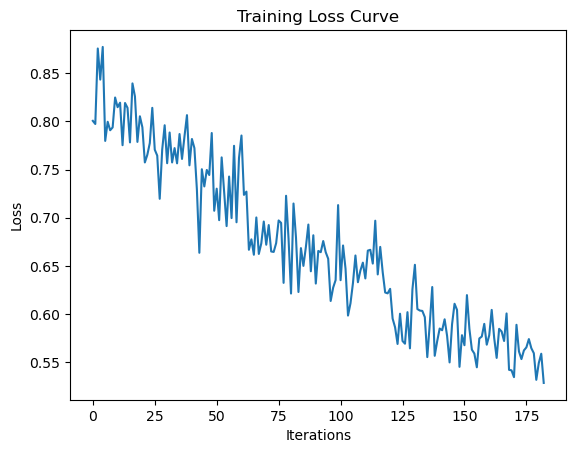

In [15]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.title("Training Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [16]:
import torch
from PIL import Image

model.eval()

def predict(image_path):
    image = Image.open(image_path).convert("RGB")
    image = dataset.transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        probs = torch.sigmoid(outputs)

    return probs.cpu().numpy()

# Example test
print(predict("images/image_0.jpg"))

[[0.60880506 0.67512065 0.4887995  0.3231124 ]]


In [17]:
def predict_labels(image_path, threshold=0.5):
    probs = predict(image_path)[0]  # get first batch result
    
    # Convert probabilities to binary labels
    binary_labels = (probs >= threshold).astype(int)
    
    print("Probabilities:", probs)
    print("Predicted Labels (0/1):", binary_labels)
    
    return binary_labels


In [18]:
predict_labels("images/image_0.jpg")

Probabilities: [0.60880506 0.67512065 0.4887995  0.3231124 ]
Predicted Labels (0/1): [1 1 0 0]


array([1, 1, 0, 0])

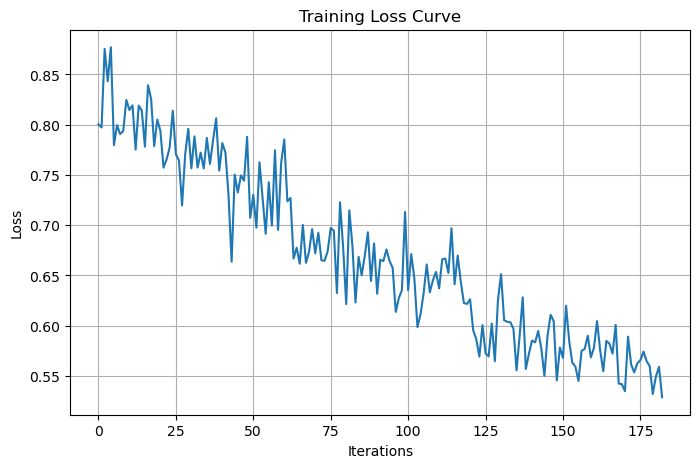

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(loss_history)
plt.title("Training Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [20]:
torch.save(model, "final_multilabel_model_full.pth")
print("Full model saved!")

Full model saved!


In [21]:
# FINAL INFERENCE CELL (For Assignment Submission)
test_image = "images/image_10.jpg"

pred = predict_labels(test_image)

print("\nFinal Prediction for:", test_image)
print("Label 1:", pred[0])
print("Label 2:", pred[1])
print("Label 3:", pred[2])
print("Label 4:", pred[3])

Probabilities: [0.43565243 0.67828465 0.5397837  0.2540748 ]
Predicted Labels (0/1): [0 1 1 0]

Final Prediction for: images/image_10.jpg
Label 1: 0
Label 2: 1
Label 3: 1
Label 4: 0


## Model Summary

- Model: ResNet18 (Pretrained)
- Task: Multi-label Classification (4 labels)
- Loss Function: BCEWithLogitsLoss with masking for NA labels
- Optimizer: Adam
- Epochs: 3
- Image Size: 224 × 224
- Special Handling: NA labels masked during loss computation


In [22]:
import torch

model_path = "final_multilabel_model_full.pth"

# FIX: allow full model loading
model = torch.load(model_path, map_location="cpu", weights_only=False)

print("✅ Model loaded successfully!")


✅ Model loaded successfully!


In [23]:
# Save BEST professional version (recommended)
torch.save(model.state_dict(), "multilabel_model.pth")
print("✅ Clean weights model saved!")


✅ Clean weights model saved!


In [24]:
torch.save(model.state_dict(), "multilabel_model.pth")

In [25]:
import torch

try:
    state_dict = torch.load("multilabel_model.pth", map_location="cpu")
    print("✅ Model file is valid and loadable!")
    print("Keys:", list(state_dict.keys())[:5])  # show some layers
except Exception as e:
    print("❌ Model file error:", e)


✅ Model file is valid and loadable!
Keys: ['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var']


In [26]:
print("\nSubmission Files Generated:")
print("1. train.ipynb - Training + Inference")
print("2. multilabel_model.pth - Trained Weights (state_dict)")
print("Model ready for evaluation ✅")


Submission Files Generated:
1. train.ipynb - Training + Inference
2. multilabel_model.pth - Trained Weights (state_dict)
Model ready for evaluation ✅


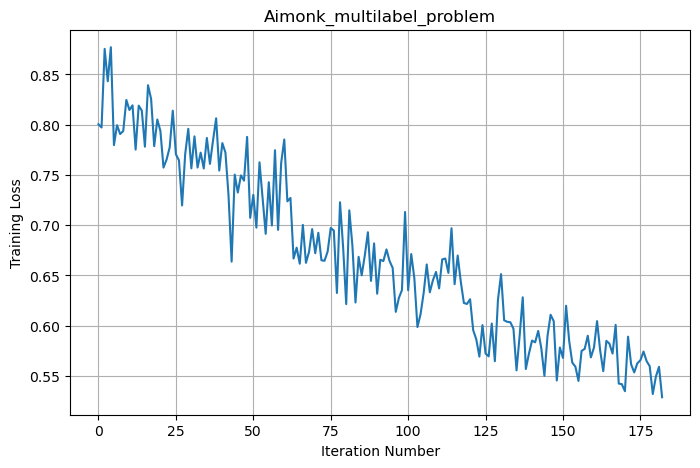

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(loss_history)
plt.xlabel("Iteration Number")
plt.ylabel("Training Loss")
plt.title("Aimonk_multilabel_problem")
plt.grid(True)
plt.show()
